## P1: Metropolis-Hastings

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def target_density(x):
    return np.sin(x)**2 * np.exp(-np.abs(x))

def metropolis_hastings_algorithm(n_samples, sigma=1.0):
    eps = 1e-10 # For numerical stability
    # Initialize states, set initial state to zero
    x = np.zeros(n_samples+1)
    for i in range(n_samples):
        xs = np.random.normal(loc=x[i], scale=sigma)
        u = np.random.uniform(low=0.0, high=1.0)
        
        # Compute acceptance probability alpha
        alpha = ( target_density(xs) * norm.pdf(x[i], loc=xs, scale=sigma) 
                  / (target_density(x[i]) * norm.pdf(xs, loc=x[i], scale=sigma) + eps) )
        alpha = min(1.0, alpha)
        
        if u <= alpha:
            x[i+1] = xs
        else:
            x[i+1] = x[i]
    return x

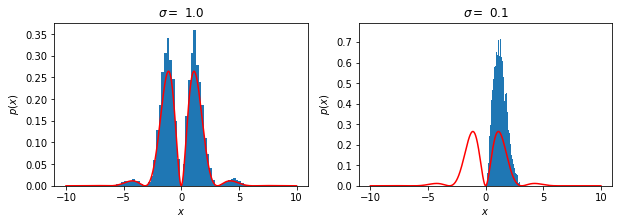

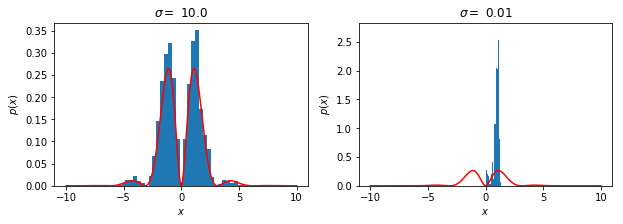

In [55]:
N = 10000
Sigma = [1.0, 0.1]
fig, axs = plt.subplots(1, 2, figsize=(10,3))
array = np.linspace(-10, 10, 1000)

for i, sigma in enumerate(Sigma):
    
    x = metropolis_hastings_algorithm(N, sigma)
    axs[i].hist(x, bins=50, density=True)
    axs[i].plot(array, target_density(array), '-r')
    axs[i].set_xlabel('$x$'); axs[i].set_ylabel('$p(x)$');
    axs[i].set_title("$\sigma =$ {}".format(sigma))

Sigma = [10.0, 0.01]
fig, axs = plt.subplots(1, 2, figsize=(10,3))

for i, sigma in enumerate(Sigma):
    
    x = metropolis_hastings_algorithm(N, sigma)
    axs[i].hist(x, bins=50, density=True)
    axs[i].plot(array, target_density(array), '-r')
    axs[i].set_xlabel('$x$'); axs[i].set_ylabel('$p(x)$');
    axs[i].set_title("$\sigma =$ {}".format(sigma))


## P2: Gibbs Sampling

In [29]:
import numpy as np
import matplotlib.pyplot as plt

def gibbs_sampler(n_samples, mu, cov, plot=False):
    # Initialize to x[0] = (0, 0)
    x = np.zeros([n_samples+1, 2])
    
    for i in range(n_samples):
        # Draw sample for x1
        cond_mean_x1 = mu[0] + cov[0, 1] * (x[i, 1] - mu[1]) / cov[1,1]
        cond_std_x1 = cov[0, 0] - (cov[0, 1]**2 / cov[1,1])
        x[i+1, 0] = np.random.normal(loc=cond_mean_x1, scale=cond_std_x1)
        
        # Draw sample for x2
        cond_mean_x2 = mu[1] + cov[0, 1] * (x[i+1, 0] - mu[0]) / cov[0,0]
        cond_std_x2 = cov[1, 1] - (cov[0, 1]**2 / cov[0, 0])
        x[i+1, 1] = np.random.normal(loc=cond_mean_x2, scale=cond_std_x2)
    return x

In [ ]:
# Code for plotting 2d Gaussian
x = np.linspace(0.0, 9.0, 1000); y = np.linspace(0.0, 6.0, 1000)
X, Y = np.meshgrid(x, y)

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

# Borrowed from: https://scipython.com/blog/visualizing-the-bivariate-gaussian-distribution/
def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos.

    pos is an array constructed by packing the meshed arrays of variables
    x_1, x_2, x_3, ..., x_k into its _last_ dimension.

    """
    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

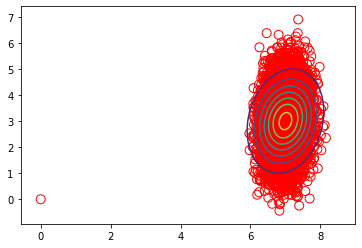

In [37]:
# Gaussian parameters
mu = np.array([7.0, 3.0])
cov = np.array([[0.3, 0.1], [0.1, 1.0]]) # Standard deviations!

Z = multivariate_gaussian(pos, mu, cov)
x = gibbs_sampler(10000, mu, cov)
plt.contour(X, Y, Z)
plt.scatter(x[:, 0], x[:, 1], s=80, facecolors='none', edgecolors='r')
plt.show()

## P3: Resampling

In [17]:
import numpy as np
import matplotlib.pyplot as plt

N = 100
m_true = 1.0 
#Generate particles fro mtarget distribution and normalized weights
x = np.random.normal(loc=m_true, scale=1.0, size=N)
w_tilde = np.random.uniform(low=1e-5, high=1.0, size=N)
w = w_tilde / np.sum(w_tilde)

# Estimate mean of target distribution
mhat = np.sum(x * w)
print("Estimate of mean: ", mhat)

Estimate of mean:  1.222195798900246


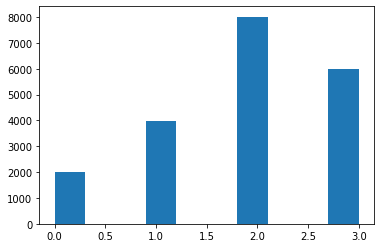

In [18]:
# See this paper: http://people.isy.liu.se/rt/schon/Publications/HolSG2006.pdf
def multinomial_resampling(w):
    N = len(w)
    # Generate ordered uniform random numbers 
    u_sample = np.random.uniform(size=N)
    u = np.zeros(N)
    u[N-1] = u_sample[N-1]**(1/N)
    for k in range(N-1, 0, -1):
        u[k-1] = u[k] * u_sample[k-1]**(1/k) 
    #print("u: ", u)
    # Generate offsprings
    ancestors = np.zeros(N, dtype=int)
    i = 0
    j = 0
    w_sum = 0.0
    while j < N:
        w_sum += w[i]
        while j < N and w_sum > u[j]:
            ancestors[j] = i
            j += 1
        i += 1 
    return ancestors
        
def systematic_resampling(w):
    N = len(w)
    # Draw random numbers uniformly from equidistant intervals
    u = np.zeros(N)
    u[0] = np.random.uniform(0.0, 1/N)
    for i in range(1,N):
        u[i] = u[i-1] + 1/N
    #print(u)
    ancestors = np.zeros(N, dtype=int)
    i = 0
    j = 0
    w_sum = 0.0
    while j < N:
        w_sum += w[i]
        while j < N and w_sum > u[j]:
            ancestors[j] = i
            j += 1
        i += 1 
    return ancestors
        
def stratified_resampling(w):
    N = len(w)
    # Draw random numbers uniformly from equidistant intervals
    u = np.zeros(N)
    for i in range(0,N):
        u[i] = np.random.uniform(low=i/N, high=(i+1)/N)
    
    ancestors = np.zeros(N, dtype=int)
    i = 0
    j = 0
    w_sum = 0.0
    while j < N:
        w_sum += w[i]
        while j < N and w_sum > u[j]:
            ancestors[j] = i
            j += 1
        i += 1 
    return ancestors
    
# TODO: Stratified and systematic resampling can be coded more efficiently
# The resampling can be made inside the for loops when sampling/computing u

np.random.seed(42)
M = 5000
ancestors = np.zeros((4, M))
for i in range(M):
    #ancestors[:, i] = multinomial_resampling([0.1, 0.2, 0.4, 0.3])
    #ancestors[:, i] = systematic_resampling([0.4, 0.2, 0.1, 0.3])
    ancestors[:, i] = stratified_resampling([0.1, 0.2, 0.4, 0.3])
fig, ax = plt.subplots()
ax.hist(np.reshape(ancestors, (4 * M,)));


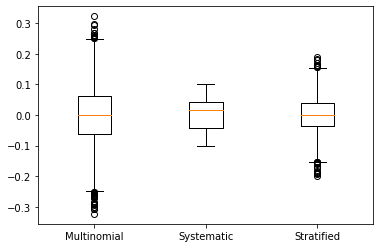

In [19]:
M = 5000
mhat_resampling = np.zeros([M, 3])
for i in range(M):
    ancestors = multinomial_resampling(w)
    mhat_resampling[i, 0] = np.mean(x[ancestors])
    
    ancestors = systematic_resampling(w)
    mhat_resampling[i, 1] = np.mean(x[ancestors])

    ancestors = stratified_resampling(w)
    mhat_resampling[i, 2] = np.mean(x[ancestors])

fig, ax = plt.subplots()
ax.boxplot(mhat_resampling - mhat, labels=['Multinomial', 'Systematic', 'Stratified']);

## P4: Path-space view

In [132]:
# Import data
import os
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

path = os.getcwd()
y = np.genfromtxt(path + '/seOMXlogreturns2012to2014.csv')

# Static parameters
phi = 0.98
sigma = 0.16
beta = 0.7

def bootstrap_particle_filter(y, n_particles, resampling_type='multinomial', ess_thres=None):
    T = len(y)
    x = np.zeros([n_particles, T+1])
    w = np.zeros([n_particles, T+1])
    ancestors = np.zeros([n_particles, T+1], dtype=int)
    
    x[:, 0] = np.random.normal(0.0, 1.0, size=n_particles)
    w[:, 0] = np.ones(n_particles) / n_particles
    ancestors[:, 0] = range(n_particles)
    
    for t in range(1, T+1):
        
        # Compute effective sample size (ESS)
        N_eff = 1 / np.sum(w[:, t-1]**2)
        
        if ess_thres is None or N_eff < ess_thres:
            if resampling_type == 'multinomial':
                ancestors[:, t] = multinomial_resampling(w[:, t-1])
            
            elif resampling_type == 'systematic':
                ancestors[:, t] = systematic_resampling(w[:, t-1])
                
            else:
                raise ValueError("Resampling type {} is unknown.".format(resampling_type))
        else:
            ancestors[:, t] = ancestors[:, t-1]
        
        #a = np.random.choice(n_particles, n_particles, p=w[:, t-1])
        #ancestors[:, t] = a # store ancestors
        x[:, t] = np.random.normal(loc=phi*x[ancestors[:, t], t-1], scale=sigma)
        log_w_tilde = norm.logpdf(y[t-1], loc=0.0, scale=np.sqrt(beta**2 * np.exp(x[:, t])))
                                  
        # Normalize with log trick
        w_bar = np.exp(log_w_tilde - np.max(log_w_tilde))
        w[:, t] = w_bar / np.sum(w_bar)
    return x, w, ancestors

def multinomial_resampling(w):
    N = len(w)
    # Generate ordered uniform random numbers 
    u_sample = np.random.uniform(size=N)
    u = np.zeros(N)
    u[N-1] = u_sample[N-1]**(1/N)
    for k in range(N-1, 0, -1):
        u[k-1] = u[k] * u_sample[k-1]**(1/k) 
    #print("u: ", u)
    # Generate offsprings
    ancestors = np.zeros(N, dtype=int)
    i = 0
    j = 0
    w_sum = 0.0
    while j < N:
        w_sum += w[i]
        while j < N and w_sum > u[j]:
            ancestors[j] = i
            j += 1
        i += 1 
    return ancestors
        
def systematic_resampling(w):
    N = len(w)
    # Draw random numbers uniformly from equidistant intervals
    u = np.zeros(N)
    u[0] = np.random.uniform(0.0, 1/N)
    for i in range(1,N):
        u[i] = u[i-1] + 1/N
    #print(u)
    ancestors = np.zeros(N, dtype=int)
    i = 0
    j = 0
    w_sum = 0.0
    while j < N:
        w_sum += w[i]
        while j < N and w_sum > u[j]:
            ancestors[j] = i
            j += 1
        i += 1 
    return ancestors


In [133]:
def plot_trajectories(x, ancestors):
    N = x.shape[0] # number pf particles
    T = x.shape[1] - 1 # number of time steps in dataset
    
    # Get trajectories of dead particles
    dead_particles = [] # Store state/particle values 

    for t in range(1, T + 1):
        dead_ind = np.setdiff1d(range(N), ancestors[:, t]) #returns unique values in first arg that are not in arg2
        traj_of_dead_ind = np.zeros((len(dead_ind), t))
        ancestors_of_dead_ind = dead_ind
        for s in range(t, 0, -1):
            #print("s: ", s)
            ancestors_of_dead_ind = ancestors[ancestors_of_dead_ind, s - 1]
            traj_of_dead_ind[:, s - 1] = x[ancestors_of_dead_ind, s - 1]

        dead_particles.append(traj_of_dead_ind)
    
    # Get trajectories of particles that survived
    alive_particles = np.zeros((N, T + 1))
    alive_particles[:, T] = x[:, T]
    ancs_t = range(n_particles)
    for t in range(T, 0, -1):
        ancs_t = ancestors[ancs_t, t - 1]
        alive_particles[:, t - 1] = x[ancs_t, t - 1]
        
    # plot dead and alive particles
    fig, ax = plt.subplots(figsize=(16, 5))
    
    for traj in dead_particles:
        for i in range(traj.shape[0]):
            ax.plot(traj[i, :], 'o-', linestyle='-', fillstyle='none', 
                    color='grey', markersize=3, lw=1,
                    alpha=0.5, antialiased=True);
    
    for i in range(N):
        ax.plot(alive_particles[i, :], 'o-', linestyle='-', markeredgecolor='r',
                    markerfacecolor='r',
                    color='k', markersize=4, lw=1,
                    alpha=1, antialiased=True);
    

    ax.set_xlabel('Time'); ax.set_ylabel('State $X$')
    ax.set_xlim(-1, T+1)
    plt.show()    

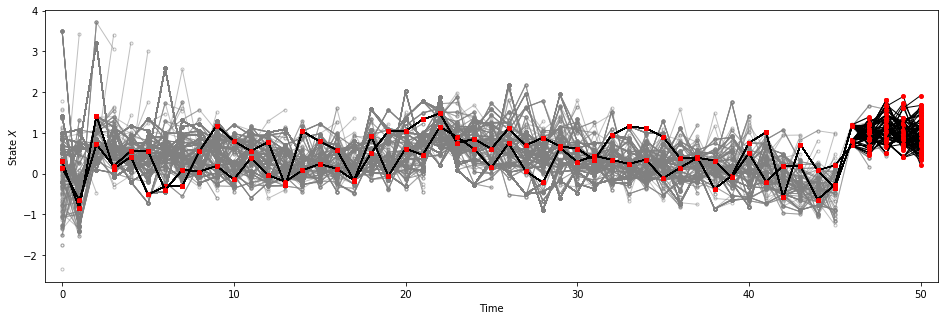

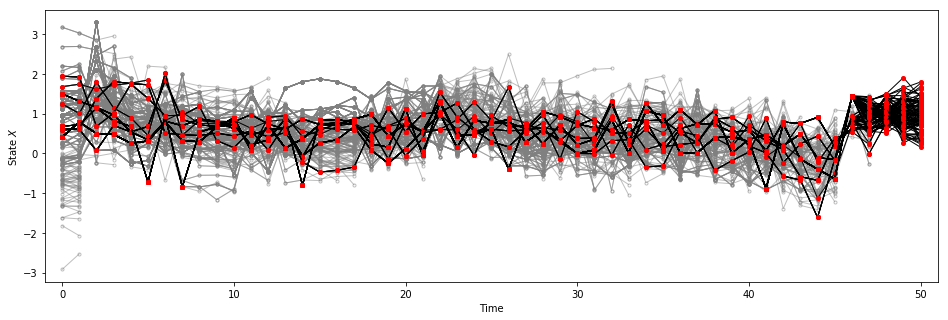

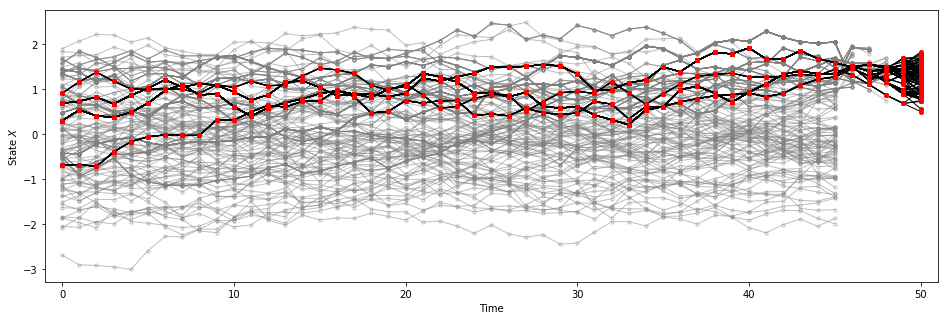

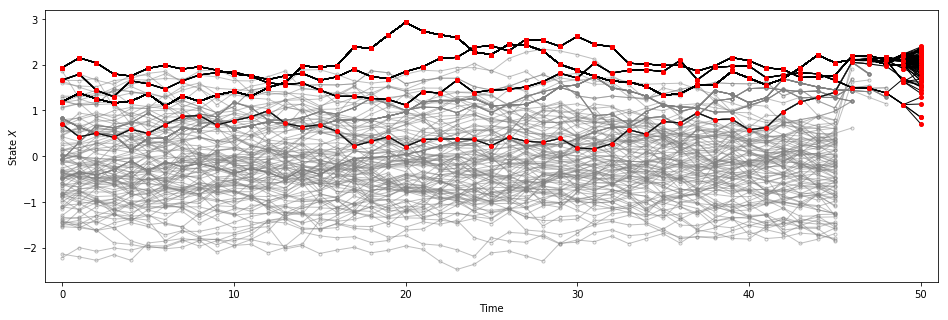

In [140]:
#np.random.seed(42)
n_particles = 100
# Multinomial resampling
x, w, a = bootstrap_particle_filter(y[:50], n_particles, resampling_type='multinomial')
plot_trajectories(x, a)

# Systematic resampling
x, w, a = bootstrap_particle_filter(y[:50], n_particles, resampling_type='systematic')
plot_trajectories(x, a)

# Multinomial resampling with ESS triggered resampling
x, w, a = bootstrap_particle_filter(y[:50], n_particles, resampling_type='multinomial', ess_thres=15)
plot_trajectories(x, a)

# Systematic resampling with ESS triggered resampling
x, w, a = bootstrap_particle_filter(y[:50], n_particles, resampling_type='systematic', ess_thres=15)
plot_trajectories(x, a)